In [1]:
from ceruleanml import data
from ceruleanml import evaluation
from ceruleanml import preprocess
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.learner import unet_learner
from fastai.data.transforms import IndexSplitter
from fastai.metrics import DiceMulti
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.vision.core import PILImageBW
from datetime import datetime
from pathlib import Path
import os, random
from icevision.visualize import show_data
import torch

In [2]:
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

### Parsing COCO Dataset with Icevision

In [3]:
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

In [4]:
with_context=False
mount_path = "/root/"
train_set = "train-no-context-512"
tiled_images_folder_train = "tiled_images_no_context"
json_name_train = "instances_TiledCeruleanDatasetV2NoContextFiles.json"

coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
val_set = "val-no-context-512"
tiled_images_folder_val= "tiled_images_no_context"
json_name_val = "instances_TiledCeruleanDatasetV2NoContextFiles.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

#with aux files
# with_context=True
# mount_path = "/root/"
# train_set = "train-with-context-512"
# tiled_images_folder_train = "tiled_images"
# json_name_train = "instances_TiledCeruleanDatasetV2.json"

# coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
# tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
# val_set = "val-with-context-512"
# tiled_images_folder_val= "tiled_images"
# json_name_val = "instances_TiledCeruleanDatasetV2.json"
# coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
# tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
negative_sample_count = 0
negative_sample_count_val = 40
area_thresh = 10
# f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

## looking at area distribution to find area threshold

In [5]:
# df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
# df

In [6]:
record_collection_with_negative_small_filtered_train = preprocess.load_set_record_collection(
    coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=False
)
record_ids_train = record_collection_to_record_ids(record_collection_with_negative_small_filtered_train)

  0%|          | 0/3863 [00:00<?, ?it/s]

In [7]:
record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=False
)
record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

  0%|          | 0/352 [00:00<?, ?it/s]

In [8]:
assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

In [9]:
train_val_record_ids = record_ids_train + record_ids_val
combined_record_collection = record_collection_with_negative_small_filtered_train + record_collection_with_negative_small_filtered_val

In [10]:
def get_val_indices(combined_ids, val_ids):
    return list(range(len(combined_ids)))[-len(val_ids):]

In [11]:
#show_data.show_records(random.choices(combined_train_records, k=9), ncols=3)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser. aug_transforms can only be used with_context=True

In [12]:
batch_transfms = [aug_transforms()]

In [13]:
val_indices = get_val_indices(train_val_record_ids, record_ids_val)

In [14]:
def get_image_by_record_id(record_id):
    return get_image_path(combined_record_collection, record_id)

def get_mask_by_record_id(record_id):
    return record_to_mask(combined_record_collection, record_id)

def create_data_block(size, with_context=True):
    imblock = ImageBlock if with_context else ImageBlock(cls=PILImageBW)
        
    coco_seg_dblock = DataBlock(
            blocks=(imblock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
            get_x=get_image_by_record_id,
            splitter=IndexSplitter(val_indices),
            get_y=get_mask_by_record_id,# *aug_transforms(),  # we need to normalize here or else fastai incorrectly normalizes by the pretrained stats
            item_tfms=Resize(size),
            n_inp=1
        )
    return coco_seg_dblock
with_context=True # duplicates single band to 3 channels
size = 256  # Progressive resizing could happen here
coco_seg_dblock = create_data_block(size, with_context=with_context)
dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=1)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


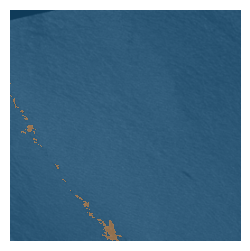

In [15]:
dls.show_batch()

### Fastai2 Trainer

In [16]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)
print(experiment_dir)

/root/experiments/cv2/09_Jun_2022_08_49_16_fastai_unet


In [17]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

In [18]:
b = dls.one_batch()

In [19]:
b[0].shape

torch.Size([1, 3, 256, 256])

In [20]:
# removed these callbacks since they cause this error: https://forums.fast.ai/t/learner-object-has-no-attribute-recorder/46328/18
# SaveModelCallback(monitor="valid_loss", with_opt=True), 
# EarlyStoppingCallback(monitor='valid_loss', min_delta=0.005, patience=5)

In [20]:
# cbs = [TensorBoardCallback(projector=False, trace_model=False)]
# learner.recorder.metric_names
learner = unet_learner(dls, archs[arch], #metrics=[DiceMulti(axis=1)]
                       model_dir=experiment_dir
                       ) #cbs=cbs# SaveModelCallback saves model when there is improvement
# lr = learner.lr_find()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [22]:
# lr

dice_multi changes a little bit when training with fewer samples. but not with more samples???

In [21]:
learner.fine_tune(2, 2e-4, freeze_epochs=1) # cbs=cbs

epoch,train_loss,valid_loss,time


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [24]:
# validation = learner.validate()  
# there's a strange bug here where an internal method is not found that should be found 
# for the Callback class. seems like a verison mismatch issue. happens if any callback included

In [25]:
size=512
# savename = f'test_6batch_{arch}_{size}_{round(validation[1],3)}.pt'
savename = f'test_6batch_{arch}_{size}.pt'

We save the best model in a variety of formats for loading later

In [26]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes

state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, savename, experiment_dir)

../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/tracing_gpu_test_6batch_18_512.pt
../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/tracing_cpu_test_6batch_18_512.pt
../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/state_dict_test_6batch_18_512.pt


In [28]:
#import pdb
#learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)


# Model Inference and Result Evaluation

import skimage.io as skio
import numpy as np
val_record_ids = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)
pred_arrs = []
val_arrs = []
for v, i in zip(range(len(record_ids_val[0:10])), record_ids_val[0:10]):
    v = record_collection_with_negative_small_filtered_val[v]
    v_masks = v.detection.masks[0].to_mask(v.common.height,v.common.width).data
    p = get_image_path(record_collection_with_negative_small_filtered_val,i)
    arr = skio.imread(p)
    # necessary for 1 channel input since fastai uses PIL during predict
    class_pred = learner.predict(np.squeeze(arr))
    class_pred = class_pred[0].cpu().detach().numpy()
    pred_arrs.append(class_pred)
    val_arrs.append(v_masks)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/metrics.py:370: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


/root/work/ceruleanml/evaluation.py:35: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


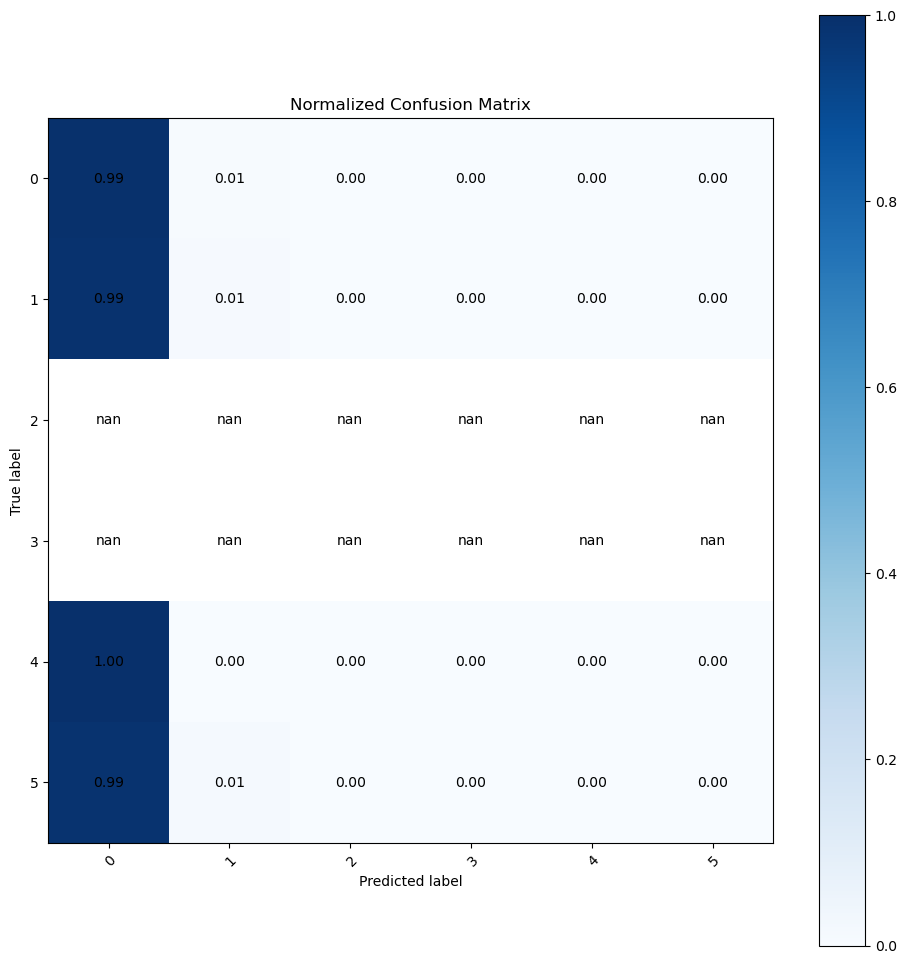

In [30]:
cm, f1 = evaluation.cm_f1(val_arrs, pred_arrs, 6, mount_path) # todo add normalize false

In [ ]:
learner = torch.load("/root/data/experiments/cv2/10_May_2022_18_02_59_fastai_unet/18_64_0.493.pkl")


import skimage.io as skio
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
with learner.no_logging():
    for i in val_record_ids:
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learner.predict(arr)
        pred_arrs.append(pred_arr)

In [ ]:
# this results in vm dying, not just kernel crash
# coco_seg_dblock = DataBlock(
#     blocks=(ImageBlock, MaskBlock(codes=class_ints)),
#     get_x=get_image_by_record_id,
#     get_y=get_mask_by_record_id,
#     n_inp=1,
# )

# dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)


In [ ]:
result = learner.get_preds(dl=dls[0])

In [ ]:
learner.get_preds??

In [ ]:
len(pred_arrs)

In [ ]:
target_label,prediction_arr, activations = pred_arrs[0]

In [ ]:
skio.imshow(target_label.cpu().detach().numpy())

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[0])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy())

In [ ]:
array([      60.73,       190.3,      4.3598]) # means
array([     16.099,      17.846,       9.603]) # stats